# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [10]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
import get_temp_amplitude
# import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
%matplotlib inline

In [11]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [12]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [13]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [14]:
plot_times_zoomed_int = scipy.ndimage.zoom(plot_times.astype('int64'), 4)
plot_times_zoomed = plot_times_zoomed_int.astype('datetime64')

In [15]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filter = scipy.signal.butter(1, [0.033, 0.05], 'band', fs=0.2, output='sos', analog=False) # 5 represents 5 second sampling rate
filtered_arr = np.empty(np.shape(plot_arr))

for i in range(len(filtered_arr.T)):
    filtered_arr[:, i] = scipy.signal.sosfilt(filter, plot_arr[:, i])
filtered_arr = scipy.ndimage.median_filter(filtered_arr, size=10, axes=1)

# Upsampling data in order to better find peaks
plot_times_zoomed_int = scipy.ndimage.zoom(plot_times.astype('int64'), 4)
plot_times_zoomed = plot_times_zoomed_int.astype('datetime64[ns]')
plot_dists_zoomed = scipy.ndimage.zoom(plot_dists, 4)
filtered_arr = scipy.ndimage.zoom(filtered_arr, 4)
plot_arr_zoom = scipy.ndimage.zoom(plot_arr, 4)

# Getting the amplitude of internal waves

In [16]:
peak_times = {}
dT = {}
peaks_arr = np.zeros(np.shape(filtered_arr))
prom = 0.2
dist = 6
w = 4
for i in tqdm(range(len(filtered_arr.T))):
    # Find peaks
    peaks_p, _ = scipy.signal.find_peaks(filtered_arr[:, i], prominence=prom, distance=dist, width=w) # prominence=0.125, distance=6, width=4
    try: peaks_p = np.delete(peaks_p, 0)
    except: print("Empty peaks")
    peaks_m, _ = scipy.signal.find_peaks(-filtered_arr[:, i], prominence=prom, distance=dist, width=w)

    peak_times[plot_dists_zoomed[i]], dT[plot_dists_zoomed[i]], peak_times_ind = get_temp_amplitude.get_temp_amplitude(peaks_p, peaks_m, filtered_arr, plot_times_zoomed_int, i)
    peaks_arr[peak_times_ind, i] = dT[plot_dists_zoomed[i]]
    # peaks = np.concatenate((peaks_p, peaks_m))

100%|██████████| 5192/5192 [00:11<00:00, 438.32it/s]


# Plot 1D slice

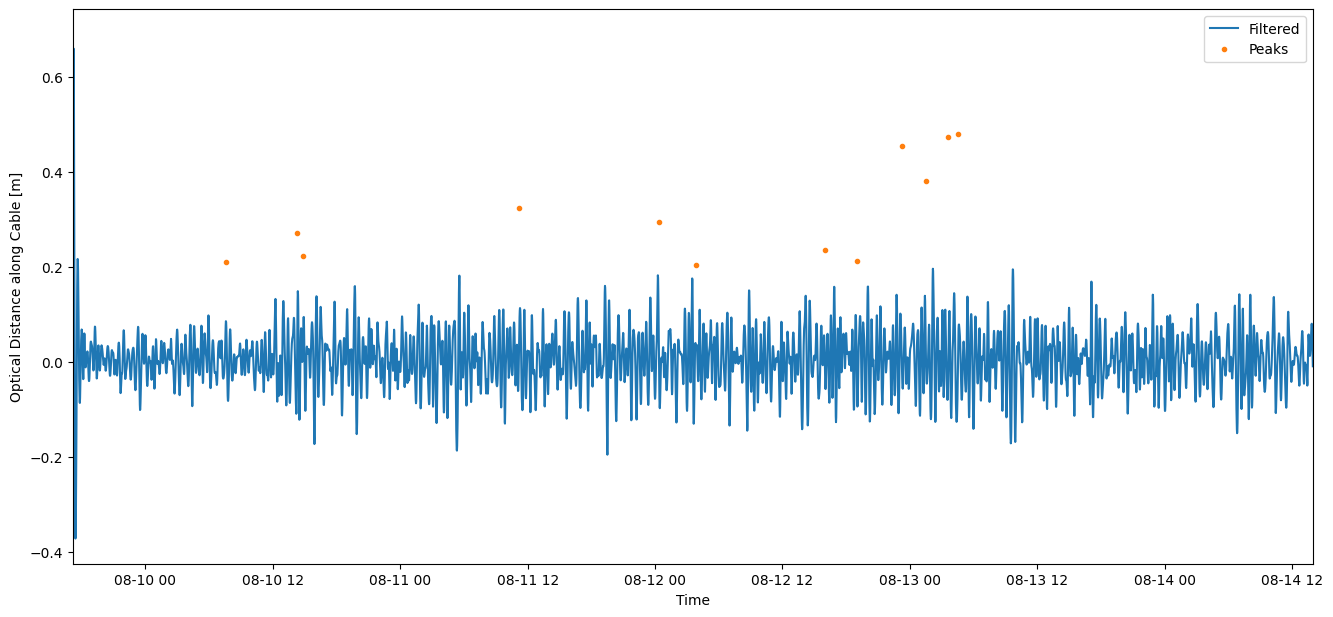

In [17]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# plt.plot(plot_times_zoomed, plot_arr_zoom[:, i])
plt.plot(plot_times_zoomed, filtered_arr[:, i])
# plt.plot(plot_times_zoomed[peaks], filtered_arr[peaks, i], 'x')
plt.plot(peak_times[plot_dists_zoomed[1400]], dT[plot_dists_zoomed[1400]], '.')
# plt.axvline(x = plot_times[100])
plt.xlim(plot_times[0], plot_times[1400])
plt.legend(['Filtered', 'Peaks', 'Peak temp separation'])

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')

plt.show()

# Band pass filtered plot

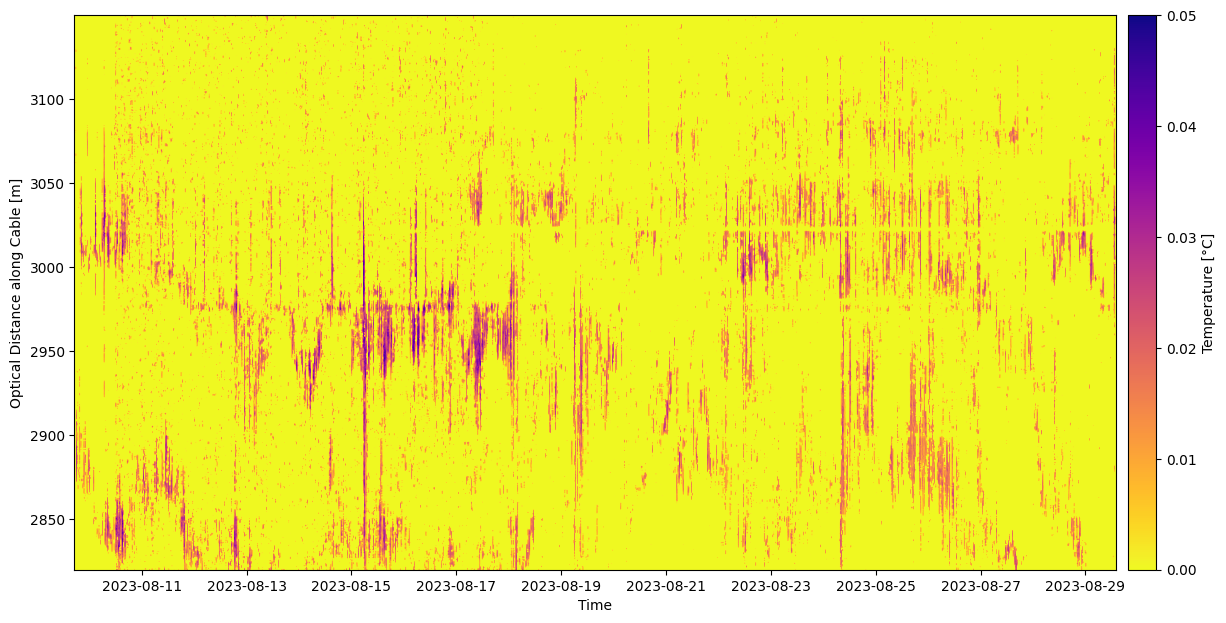

In [25]:
filter = scipy.signal.butter(1, [0.033, 0.05], 'band', fs=0.2, output='sos', analog=False) # 5 represents 5 second sampling rate
filtered_arr = np.empty(np.shape(plot_arr))
for i in range(len(filtered_arr.T)):
    filtered_arr[:, i] = scipy.signal.sosfilt(filter, plot_arr[:, i])
filtered_arr = scipy.ndimage.median_filter(filtered_arr, size=10, axes=1)


# # Testing with 1D case
# filtered_arr = scipy.signal.sosfilt(filter, plot_arr[:, 0])

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# i = 456
# plt.plot(plot_dists, plot_arr[i, :])
# plt.plot(plot_dists, filtered_arr[i, :])
# plt.legend(['Original', 'Filtered'])

# Full 2D case
im1 = ax.imshow(peaks_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma_r',
            vmin=0,
            vmax=0.05,
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )
X, Y = np.meshgrid(plot_times,   plot_dists)
# isotherms = ax.contour(X, Y, plot_arr.T, [0.8, 1.3, 2])

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature [°C]')
plt.show()

# Original temp plot for reference

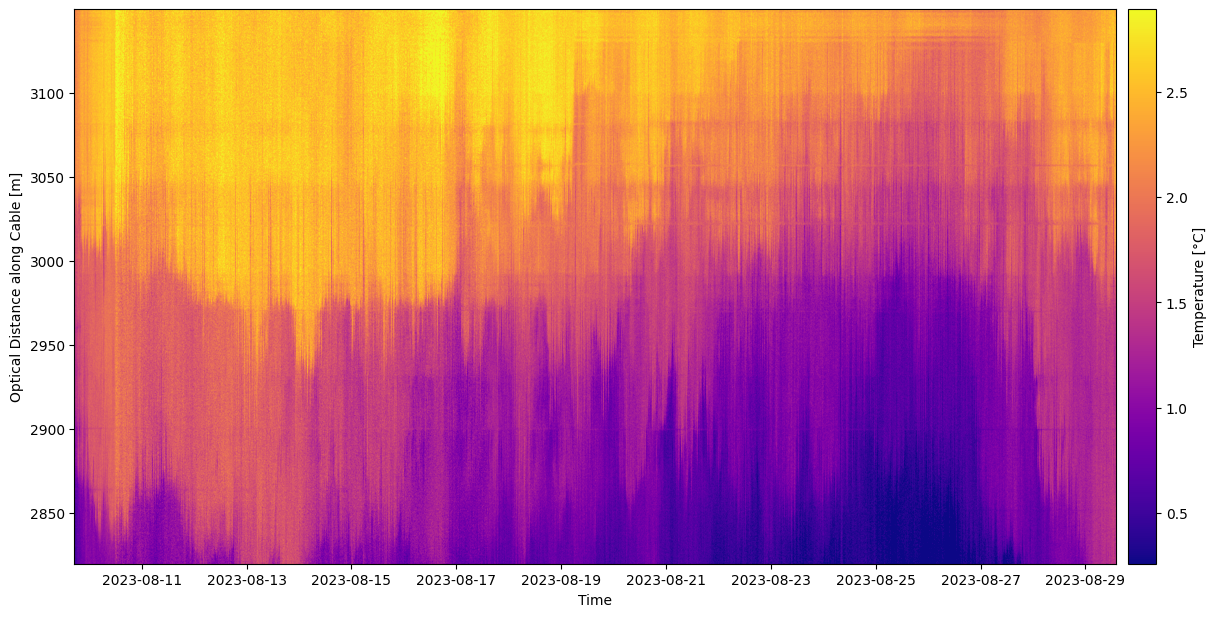

In [19]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im1 = ax.imshow(plot_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )
X, Y = np.meshgrid(plot_times, plot_dists)
# isotherms = ax.contour(X, Y, plot_arr.T, [0.8, 1.3, 2])

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature [°C]')
plt.show()